# Ensembles and feature importances

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm.sklearn import LGBMRegressor

from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge

from sklearn.model_selection import (
    cross_val_score,
    cross_validate,
    train_test_split,
)

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor, export_graphviz

import altair as alt
alt.renderers.enable('mimetype')
alt.data_transformers.enable("data_server")

%matplotlib inline

<br><br>

##  1: Data and preprocessing
<hr>

I will be using Kaggle's [Spotify Tracks DB](https://www.kaggle.com/zaheenhamidani/ultimate-spotify-tracks-db) dataset. The features in this dataset are similar to Kaggle's [Spotify Song Attributes](https://www.kaggle.com/geomack/spotifyclassification/home) dataset that I used in the first project. But the prediction task for this dataset is a regression task of predicting song popularity. See the documentation of spotify-specific features [here](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/). 


In [2]:
spotify_df = pd.read_csv("../downloads/SpotifyFeatures.csv")
spotify_df.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


I'm cleaning up the CSV a bit. In particular, 

1. I'm changing popularity of 0 to 1 to avoid divide by zero errors later. Note that the popularity ranges from 0 to 100, with 0 being least popular and 100 being most popular. So changing the popularity from 0 to 1 should not make a huge difference.
2. Seems like the genre feature has two slightly different versions of the category Children's Music with two different quotation marks (` and '). I'm mapping them both to "Children's Music".  

In [3]:
spotify_df.loc[spotify_df["popularity"] == 0, "popularity"] = 1

In [4]:
spotify_df["genre"].value_counts()

Comedy              9681
Soundtrack          9646
Indie               9543
Jazz                9441
Pop                 9386
Electronic          9377
Children’s Music    9353
Folk                9299
Hip-Hop             9295
Rock                9272
Alternative         9263
Classical           9256
Rap                 9232
World               9096
Soul                9089
Blues               9023
R&B                 8992
Anime               8936
Reggaeton           8927
Ska                 8874
Reggae              8771
Dance               8701
Country             8664
Opera               8280
Movie               7806
Children's Music    5403
A Capella            119
Name: genre, dtype: int64

In [5]:
spotify_df.loc[spotify_df["genre"] == "Children’s Music", "genre"] = "Children's Music"

This dataset is large and in this project I want to explore ensemble methods which can be computationally intensive. So when we split the data, I am putting most of the data in the test split. If your computer can handle it, you are welcome to experiment with a bigger training split. 

In [6]:
spotify_df.shape

(232725, 18)

In [7]:
train_df, test_df = train_test_split(spotify_df, test_size=0.97, random_state=123)

In [8]:
train_df.shape

(6981, 18)

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6981 entries, 57856 to 15725
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   genre             6981 non-null   object 
 1   artist_name       6981 non-null   object 
 2   track_name        6981 non-null   object 
 3   track_id          6981 non-null   object 
 4   popularity        6981 non-null   int64  
 5   acousticness      6981 non-null   float64
 6   danceability      6981 non-null   float64
 7   duration_ms       6981 non-null   int64  
 8   energy            6981 non-null   float64
 9   instrumentalness  6981 non-null   float64
 10  key               6981 non-null   object 
 11  liveness          6981 non-null   float64
 12  loudness          6981 non-null   float64
 13  mode              6981 non-null   object 
 14  speechiness       6981 non-null   float64
 15  tempo             6981 non-null   float64
 16  time_signature    6981 non-null   obj

I am defining different feature types and a couple of preprocessors below.  

In [10]:
drop_features = ["track_id", "artist_name"]
binary_features = ["mode"]
categorical_features = ["genre", "time_signature", "key"]
text_feature = "track_name"
target = "popularity"
numeric_features = list(
    set(train_df.columns)
    - set(drop_features)
    - set([text_feature])
    - set(binary_features)
    - set(categorical_features)
    - set([target])
)
assert train_df.columns.shape[0] == len(
    drop_features
    + binary_features
    + categorical_features
    + numeric_features
    + [text_feature]
    + [target]
)

In [11]:
preprocessor_num_bin = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(drop="if_binary", dtype="int"), binary_features),
    ("drop", drop_features),
)  # preprocessor which includes only numeric and binary features

In [12]:
preprocessor_all = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(drop="if_binary", dtype="int"), binary_features),
    (OneHotEncoder(handle_unknown="ignore", dtype="int"), categorical_features),
    (CountVectorizer(stop_words="english", max_features=100), text_feature),
    ("drop", drop_features),
)  # preprocessor which includes all features

In [13]:
X_train, y_train = train_df.drop(columns=[target]), train_df[target]
X_test, y_test = test_df.drop(columns=[target]), test_df[target]

In [14]:
preprocessor_num_bin.fit(X_train)
preprocessor_all.fit(X_train);

OK. Seems like both preprocessors are working OK. 

<br><br>

##  2: Ensembles with Numeric Features only
<hr>

Now that we have preprocessed data, let's try some models. In this , we will explore ensembles with the preprocessor `preprocessor_num_bin`, which includes only binary and numeric features. 


### 2.1 Dummy regressor - baseline


In [15]:
from sklearn.metrics import make_scorer


def mape(true, pred):
    return 100.0 * np.mean(np.abs((pred - true) / true))


# make a scorer function that we can pass into cross-validation
mape_scorer = make_scorer(mape, greater_is_better=False)

scoring_metrics = {
    "neg RMSE": "neg_root_mean_squared_error",
    "r2": "r2",
    "mape": mape_scorer,
}

In [16]:
results = {}

In [17]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation
    adapted from MDS lectures

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [18]:
dummy_pipe = make_pipeline(preprocessor_num_bin, DummyRegressor())
results["Dummy Regressor"] = mean_std_cross_val_scores(dummy_pipe, X_train, y_train, return_train_score=True, scoring=scoring_metrics)
pd.DataFrame(results)

,Dummy Regressor
fit_time,0.011 (+/- 0.007)
score_time,0.010 (+/- 0.008)
test_neg RMSE,-18.105 (+/- 0.329)
train_neg RMSE,-18.102 (+/- 0.083)
test_r2,-0.002 (+/- 0.001)
train_r2,0.000 (+/- 0.000)
test_mape,-193.549 (+/- 16.812)
train_mape,-193.505 (+/- 3.874)


<br><br>

### 2.2 Decision tree regressor - second baseline

Let's use decision tree as our second baseline. 

 

In [19]:
dtr_pipe = make_pipeline(preprocessor_num_bin, DecisionTreeRegressor())
results["Decision Tree Regressor"] = mean_std_cross_val_scores(dtr_pipe, X_train, y_train, return_train_score=True, scoring=scoring_metrics)
pd.DataFrame(results)

,Dummy Regressor,Decision Tree Regressor
fit_time,0.011 (+/- 0.007),0.080 (+/- 0.005)
score_time,0.010 (+/- 0.008),0.010 (+/- 0.009)
test_neg RMSE,-18.105 (+/- 0.329),-20.926 (+/- 0.272)
train_neg RMSE,-18.102 (+/- 0.083),-0.118 (+/- 0.019)
test_r2,-0.002 (+/- 0.001),-0.338 (+/- 0.025)
train_r2,0.000 (+/- 0.000),1.000 (+/- 0.000)
test_mape,-193.549 (+/- 16.812),-147.065 (+/- 21.708)
train_mape,-193.505 (+/- 3.874),-0.016 (+/- 0.003)


<br><br>

### 2.3 Different models 

We define pipelines for each regressor listed below with the first step as `preprocessor_num_bin` from  1 and second step as the regressor. Using `random_state=123` for all models is for reproducability. We store all the models in a dictionary called `models`, where keys are regressor names and values are pipelines. We will be using this `model` dictionary later in voting and stacking models. 

- `Ridge`
- [`RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
- [`XGBoostRegressor`](https://xgboost.readthedocs.io/en/latest/python/python_api.html)
- [`LGBMRegressor`](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html)    
- [`CatBoostRegressor`](https://catboost.ai/docs/concepts/python-reference_catboostregressor)

In [20]:
regressors = {
    "Ridge": Ridge(max_iter=1000),
    "Random Forest": RandomForestRegressor(random_state=123),
    "XGBoost": XGBRegressor(verbosity=0,
                           eval_metric="logloss",
                           random_state=123),
    "Light GBM": LGBMRegressor(verbose=0,
                              force_col_wise=True,
                              random_state=123),
    "CatBoost": CatBoostRegressor(verbose=0,
                                 random_state=123)
}

for name, model in regressors.items():
    pipe = make_pipeline(preprocessor_num_bin, model)
    results[name] = mean_std_cross_val_scores(pipe, X_train, y_train, return_train_score=True, scoring=scoring_metrics)

pd.DataFrame(results)

,Dummy Regressor,Decision Tree Regressor,Ridge,Random Forest,XGBoost,Light GBM,CatBoost
fit_time,0.011 (+/- 0.007),0.080 (+/- 0.005),0.018 (+/- 0.006),3.930 (+/- 0.025),0.567 (+/- 0.011),0.138 (+/- 0.007),3.107 (+/- 0.129)
score_time,0.010 (+/- 0.008),0.010 (+/- 0.009),0.002 (+/- 0.003),0.037 (+/- 0.008),0.009 (+/- 0.009),0.013 (+/- 0.007),0.017 (+/- 0.005)
test_neg RMSE,-18.105 (+/- 0.329),-20.926 (+/- 0.272),-15.873 (+/- 0.327),-14.804 (+/- 0.407),-15.690 (+/- 0.418),-14.939 (+/- 0.448),-14.896 (+/- 0.333)
train_neg RMSE,-18.102 (+/- 0.083),-0.118 (+/- 0.019),-15.840 (+/- 0.081),-5.577 (+/- 0.055),-6.777 (+/- 0.144),-10.917 (+/- 0.058),-9.832 (+/- 0.109)
test_r2,-0.002 (+/- 0.001),-0.338 (+/- 0.025),0.230 (+/- 0.021),0.330 (+/- 0.026),0.247 (+/- 0.040),0.318 (+/- 0.031),0.322 (+/- 0.023)
train_r2,0.000 (+/- 0.000),1.000 (+/- 0.000),0.234 (+/- 0.005),0.905 (+/- 0.002),0.860 (+/- 0.007),0.636 (+/- 0.003),0.705 (+/- 0.006)
test_mape,-193.549 (+/- 16.812),-147.065 (+/- 21.708),-161.321 (+/- 13.786),-137.544 (+/- 15.154),-135.972 (+/- 16.469),-135.424 (+/- 17.275),-133.561 (+/- 16.015)
train_mape,-193.505 (+/- 3.874),-0.016 (+/- 0.003),-160.987 (+/- 3.134),-50.609 (+/- 1.712),-45.532 (+/- 2.015),-92.692 (+/- 2.571),-77.994 (+/- 2.494)


<br><br>

### 2.4 Analysis 


According to the scoring criteria Random Forest gives the best RMSE and r2 score, and CatBoost has the best mape CV score. However, since the scores for tree-based models are very close, the ordering of the best model could change with different random states, but will most probably be one of the tree-based models. Not including Dummy Regressor, the worst model is decision tree although it has a better mape score compared to Ridge. However, as we can see for the r2 train score (of 1.0) and close-to-zero mape train score for Decision Tree, this model is clearly overfitting.  

For fit time, Ridge is the quickest which makes sense because it is only training one model rather than training multiple ones which is the case for ensemble models. The longest fit time is for CatBoost.  

Although Catboost has a high fit time, its score time is comparable with Ridge and Decision Tree which have the fastest score time. Random forest has the worst score time.

<br><br>

### 2.5 Voting regressor 

Using `sklearn`'s [`VotingRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html) we will create an averaging model.

> This might take a few minutes to run. 

In [21]:
estimators = [
    ("Ridge", Ridge(max_iter=1000)),
    ("Random Forest", RandomForestRegressor(random_state=123)),
    ("XGBoost", XGBRegressor(verbosity=0,
                            eval_metric="logloss",
                            random_state=123)),
    ("Light GBM", LGBMRegressor(verbose=0,
                               force_col_wise=True,
                               random_state=123)),
    ("CatBoost", CatBoostRegressor(verbose=0,
                                  random_state=123))
]

vote_reg = VotingRegressor(estimators)

vote_pipe = make_pipeline(preprocessor_num_bin, vote_reg)
results["Voting Regressor"] = mean_std_cross_val_scores(vote_pipe, X_train, y_train, return_train_score=True, scoring=scoring_metrics)
pd.DataFrame(results)

,Dummy Regressor,Decision Tree Regressor,Ridge,Random Forest,XGBoost,Light GBM,CatBoost,Voting Regressor
fit_time,0.011 (+/- 0.007),0.080 (+/- 0.005),0.018 (+/- 0.006),3.930 (+/- 0.025),0.567 (+/- 0.011),0.138 (+/- 0.007),3.107 (+/- 0.129),7.950 (+/- 0.160)
score_time,0.010 (+/- 0.008),0.010 (+/- 0.009),0.002 (+/- 0.003),0.037 (+/- 0.008),0.009 (+/- 0.009),0.013 (+/- 0.007),0.017 (+/- 0.005),0.050 (+/- 0.001)
test_neg RMSE,-18.105 (+/- 0.329),-20.926 (+/- 0.272),-15.873 (+/- 0.327),-14.804 (+/- 0.407),-15.690 (+/- 0.418),-14.939 (+/- 0.448),-14.896 (+/- 0.333),-14.778 (+/- 0.395)
train_neg RMSE,-18.102 (+/- 0.083),-0.118 (+/- 0.019),-15.840 (+/- 0.081),-5.577 (+/- 0.055),-6.777 (+/- 0.144),-10.917 (+/- 0.058),-9.832 (+/- 0.109),-9.343 (+/- 0.051)
test_r2,-0.002 (+/- 0.001),-0.338 (+/- 0.025),0.230 (+/- 0.021),0.330 (+/- 0.026),0.247 (+/- 0.040),0.318 (+/- 0.031),0.322 (+/- 0.023),0.332 (+/- 0.027)
train_r2,0.000 (+/- 0.000),1.000 (+/- 0.000),0.234 (+/- 0.005),0.905 (+/- 0.002),0.860 (+/- 0.007),0.636 (+/- 0.003),0.705 (+/- 0.006),0.734 (+/- 0.003)
test_mape,-193.549 (+/- 16.812),-147.065 (+/- 21.708),-161.321 (+/- 13.786),-137.544 (+/- 15.154),-135.972 (+/- 16.469),-135.424 (+/- 17.275),-133.561 (+/- 16.015),-139.655 (+/- 15.592)
train_mape,-193.505 (+/- 3.874),-0.016 (+/- 0.003),-160.987 (+/- 3.134),-50.609 (+/- 1.712),-45.532 (+/- 2.015),-92.692 (+/- 2.571),-77.994 (+/- 2.494),-84.531 (+/- 1.973)


#### Discussion

- A total of 5 regressors from 2.3 are being averaged here. Although RMSE has slightly imporoved, r2 and mape have not. This could be contributed to the fact that voting regressor averages the results, and since average is sensitive to outliers (Ridge in this case), we are getting worse scores.  
- `VotingRegressor` returns the average of the individual predictions of the models to form a final prediction. On the other hand, `VotingClassifier` combines different classifiers and uses a majority vote or the average predicted probabilities (soft vote) to predict the class labels.

<br><br>

### 2.6 Stacking regressor 

We now create a stacking model using [`sklearn's` `StackingRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html) with the estimators from  2.3, and `Ridge` as the final estimator.

In [22]:
# list of estimators is acquired from 2.5
stack = StackingRegressor(estimators, final_estimator=Ridge(max_iter=1000))
stack_pipe = make_pipeline(preprocessor_num_bin, stack)
results["Stacking Regressor"] = mean_std_cross_val_scores(stack_pipe, X_train, y_train, return_train_score=True, scoring=scoring_metrics)

In [23]:
pd.DataFrame(results)

,Dummy Regressor,Decision Tree Regressor,Ridge,Random Forest,XGBoost,Light GBM,CatBoost,Voting Regressor,Stacking Regressor
fit_time,0.011 (+/- 0.007),0.080 (+/- 0.005),0.018 (+/- 0.006),3.930 (+/- 0.025),0.567 (+/- 0.011),0.138 (+/- 0.007),3.107 (+/- 0.129),7.950 (+/- 0.160),55.308 (+/- 27.271)
score_time,0.010 (+/- 0.008),0.010 (+/- 0.009),0.002 (+/- 0.003),0.037 (+/- 0.008),0.009 (+/- 0.009),0.013 (+/- 0.007),0.017 (+/- 0.005),0.050 (+/- 0.001),0.059 (+/- 0.007)
test_neg RMSE,-18.105 (+/- 0.329),-20.926 (+/- 0.272),-15.873 (+/- 0.327),-14.804 (+/- 0.407),-15.690 (+/- 0.418),-14.939 (+/- 0.448),-14.896 (+/- 0.333),-14.778 (+/- 0.395),-14.700 (+/- 0.381)
train_neg RMSE,-18.102 (+/- 0.083),-0.118 (+/- 0.019),-15.840 (+/- 0.081),-5.577 (+/- 0.055),-6.777 (+/- 0.144),-10.917 (+/- 0.058),-9.832 (+/- 0.109),-9.343 (+/- 0.051),-8.473 (+/- 0.250)
test_r2,-0.002 (+/- 0.001),-0.338 (+/- 0.025),0.230 (+/- 0.021),0.330 (+/- 0.026),0.247 (+/- 0.040),0.318 (+/- 0.031),0.322 (+/- 0.023),0.332 (+/- 0.027),0.340 (+/- 0.024)
train_r2,0.000 (+/- 0.000),1.000 (+/- 0.000),0.234 (+/- 0.005),0.905 (+/- 0.002),0.860 (+/- 0.007),0.636 (+/- 0.003),0.705 (+/- 0.006),0.734 (+/- 0.003),0.781 (+/- 0.013)
test_mape,-193.549 (+/- 16.812),-147.065 (+/- 21.708),-161.321 (+/- 13.786),-137.544 (+/- 15.154),-135.972 (+/- 16.469),-135.424 (+/- 17.275),-133.561 (+/- 16.015),-139.655 (+/- 15.592),-137.344 (+/- 15.358)
train_mape,-193.505 (+/- 3.874),-0.016 (+/- 0.003),-160.987 (+/- 3.134),-50.609 (+/- 1.712),-45.532 (+/- 2.015),-92.692 (+/- 2.571),-77.994 (+/- 2.494),-84.531 (+/- 1.973),-75.763 (+/- 3.371)


#### Discussion
- With the Stacking Regressor we see an improvement in RMSE compared to Voting regressor, but but it is taking much longer time to run (5 times) because of the extra cross validation. Mape and r2 did not improve much compared to Voting Regressor.

<br><br>

### 2.7 Examining coefficients

Below I will show constituent regressor names and their corresponding coefficients learned by the final estimator in our stacking model. 

According to the below calculations, Random Forest has the biggest coefficient. This means that from the outputs of the five regressors, Random Forest has been fitted to predict the target the best, and in turn it has been given the highest coefficient. The least trustful model is XGBoost.

In [24]:
stack_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['energy', 'tempo',
                                                   'instrumentalness',
                                                   'danceability',
                                                   'acousticness', 'liveness',
                                                   'duration_ms', 'valence',
                                                   'loudness', 'speechiness']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype='int'),
                                                  ['mode']),
                                                 ('drop', 'drop',
                            

In [25]:
coefficients = stack_pipe.named_steps["stackingregressor"].final_estimator_.coef_.flatten()

In [26]:
models = []
for name, model in estimators:
    models.append(name)
models

['Ridge', 'Random Forest', 'XGBoost', 'Light GBM', 'CatBoost']

In [27]:
pd.DataFrame(data=coefficients,
            index=models,
            columns=["Coefficients"]).sort_values("Coefficients", ascending=False)

,Coefficients
Random Forest,0.467438
CatBoost,0.330981
Light GBM,0.187812
Ridge,0.095934
XGBoost,-0.057768


<br><br>

### 2.8 Tree-based models without scaling


Technically, scaling shouldn't affect the results of tree-based models, because on each node of a tree we will train the model to identify the threshold on only one feature, and therefore, it doesn't matter if it is scaled or not. 

<br><br>

##  3: Tree-based models with all features <a name="3"></a>
<hr>

### 3.1 Different models with all features

In the previous section, I trained models only with numeric and binary features. Let's incorporate categorical and text features in the pipeline to see if I get a different result.

In [28]:
models = {
    "Ridge": make_pipeline(preprocessor_all, Ridge(max_iter=1000)),
    "Random Forest": make_pipeline(
        preprocessor_all, RandomForestRegressor(random_state=123)
    ),
    "XGBoost": make_pipeline(
        preprocessor_all,
        XGBRegressor(verbosity=0, eval_metric="logloss", random_state=123),
    ),
    "Light GBM": make_pipeline(
        preprocessor_all,
        LGBMRegressor(verbose=0, force_col_wise=True, random_state=123),
    ),
    "CatBoost": make_pipeline(
        preprocessor_all, CatBoostRegressor(verbose=0, random_state=123)
    ),
}

results_all_feat = {}
for model, pipe in models.items():
    results_all_feat[model] = mean_std_cross_val_scores(pipe, X_train, y_train, return_train_score=True, scoring=scoring_metrics)
    
pd.DataFrame(results_all_feat)

,Ridge,Random Forest,XGBoost,Light GBM,CatBoost
fit_time,0.095 (+/- 0.020),24.982 (+/- 0.666),0.646 (+/- 0.026),0.349 (+/- 0.024),4.070 (+/- 0.233)
score_time,0.020 (+/- 0.006),0.061 (+/- 0.024),0.035 (+/- 0.006),0.047 (+/- 0.001),0.025 (+/- 0.002)
test_neg RMSE,-11.086 (+/- 0.236),-10.623 (+/- 0.417),-10.674 (+/- 0.344),-10.408 (+/- 0.387),-10.149 (+/- 0.289)
train_neg RMSE,-10.788 (+/- 0.057),-3.910 (+/- 0.038),-5.268 (+/- 0.143),-7.799 (+/- 0.057),-7.080 (+/- 0.060)
test_r2,0.624 (+/- 0.011),0.655 (+/- 0.023),0.652 (+/- 0.018),0.669 (+/- 0.019),0.685 (+/- 0.015)
train_r2,0.645 (+/- 0.003),0.953 (+/- 0.001),0.915 (+/- 0.005),0.814 (+/- 0.003),0.847 (+/- 0.001)
test_mape,-108.499 (+/- 12.843),-87.785 (+/- 12.586),-87.283 (+/- 11.534),-85.653 (+/- 13.173),-82.388 (+/- 10.279)
train_mape,-104.686 (+/- 1.949),-31.234 (+/- 1.124),-32.706 (+/- 2.441),-58.430 (+/- 2.117),-49.745 (+/- 1.586)


#### Observations

- We see huge improvement in all of our scores using better features. 
- The other observation is that we are also getting very good scores with a simple interpretable Ridge model, and we don't need to be using fancier tree-based models. Although Ridge is a simpler model than Random Forest, it is worth moving to Random Forest as there is a large improvement in scores.

<br><br>

### 3.2 True popularity vs predictions  

Next we get the predictions on the training set using the best performing regressor from 3.1, and plot true popularity vs. predicted popularity on the training set to see if the model is overestimating or underestimating the popularity. 

In [29]:
best_pipe = make_pipeline(
        preprocessor_all, RandomForestRegressor(random_state=123)
    )
best_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['energy', 'tempo',
                                                   'instrumentalness',
                                                   'danceability',
                                                   'acousticness', 'liveness',
                                                   'duration_ms', 'valence',
                                                   'loudness', 'speechiness']),
                                                 ('onehotencoder-1',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype='int'),
                                                  ['mode']),
                                                 ('onehotencoder-2',
                       

In [30]:
predictions = best_pipe.predict(X_test)
comparison = pd.DataFrame({"True popularity": y_test.copy(), 
                           "Predicted popularity": predictions})
comparison.head()

,True popularity,Predicted popularity
116505,58,60.39
147921,44,44.68
229940,44,44.98
107239,10,16.68
102112,56,54.19


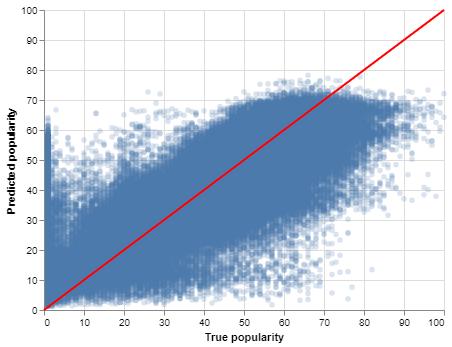

In [31]:
(alt.Chart(comparison).mark_circle(opacity=0.2).encode(
    x = "True popularity",
    y = "Predicted popularity"
)
+ alt.Chart(pd.DataFrame({
    'True popularity': [0, 100],
    'Predicted popularity': [0, 100],
    })).mark_line(color="red").encode(
    x = "True popularity",
    y = "Predicted popularity"
    )
)

#### Observation

According to the plot above, this model seems to be underestimating since the points are mostly located below the y=x line and close to the `True popularity` axis.

<br><br>

### 3.3 Ridge coefficients

I train a `Ridge` pipeline with all features to get feature names and store them in a variable called `feature_names`. (We'll be using this variable later in 4.)

I have created a dataframe with `feature_names` and corresponding coefficients learned by the `Ridge` model to show first few most important features. 

In [32]:
ridge_pipe = make_pipeline(preprocessor_all, Ridge(max_iter=1000))
ridge_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['energy', 'tempo',
                                                   'instrumentalness',
                                                   'danceability',
                                                   'acousticness', 'liveness',
                                                   'duration_ms', 'valence',
                                                   'loudness', 'speechiness']),
                                                 ('onehotencoder-1',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype='int'),
                                                  ['mode']),
                                                 ('onehotencoder-2',
                       

In [33]:
binary_features = ["mode"]
categorical_features = ["genre", "time_signature", "key"]
text_feature = "track_name"

numeric_features = list(
    set(train_df.columns)
    - set(drop_features)
    - set([text_feature])
    - set(binary_features)
    - set(categorical_features)
    - set([target])
)

In [34]:
feature_names = (
    numeric_features
    + binary_features
    + ridge_pipe.named_steps["columntransformer"]
    .named_transformers_["onehotencoder-2"]
    .get_feature_names_out().tolist()
    + ridge_pipe.named_steps["columntransformer"]
    .named_transformers_["countvectorizer"]
    .get_feature_names_out().tolist()
)

In [35]:
coefficients = ridge_pipe.named_steps['ridge'].coef_.tolist()

In [36]:
features_coef = pd.DataFrame(coefficients, index=feature_names, columns=["coefficient"])
features_coef["magnitude"] = np.abs(features_coef)
features_coef.sort_values("magnitude", ascending=False)[:10]

,coefficient,magnitude
genre_Movie,-25.860578,25.860578
genre_Pop,24.488308,24.488308
genre_A Capella,-23.786548,23.786548
genre_Opera,-22.140173,22.140173
genre_Rap,19.603940,19.603940
genre_Hip-Hop,18.411460,18.411460
genre_Rock,17.643133,17.643133
genre_Anime,-16.606411,16.606411
genre_Dance,15.162323,15.162323
genre_Indie,13.052756,13.052756


<br><br>

### 3.4 Random forest feature importances

`Ridge` is quite interpretable in terms of feature importances and the sign of the coefficient (negative or positive) shows how that coefficent is contributing to the target value. We get feature importances of the random forest model to see if we could get a similar intuition. 


In [37]:
rf_pipe = make_pipeline(
        preprocessor_all, RandomForestRegressor(random_state=123)
    )
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['energy', 'tempo',
                                                   'instrumentalness',
                                                   'danceability',
                                                   'acousticness', 'liveness',
                                                   'duration_ms', 'valence',
                                                   'loudness', 'speechiness']),
                                                 ('onehotencoder-1',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype='int'),
                                                  ['mode']),
                                                 ('onehotencoder-2',
                       

In [38]:
rf_imp = rf_pipe.named_steps['randomforestregressor'].feature_importances_.tolist()
rf_feat_imp = pd.DataFrame(rf_imp, index=feature_names, columns=["rf_feature_importance"])
rf_feat_imp.sort_values("rf_feature_importance", ascending=False)[:10]

,rf_feature_importance
acousticness,0.190323
genre_Movie,0.065080
genre_Pop,0.050678
duration_ms,0.043304
loudness,0.039747
genre_Rap,0.037510
genre_Children's Music,0.034900
liveness,0.032847
speechiness,0.032276
genre_Anime,0.032276


As shown above, with sklearn feature importance score for Random Forest we can see what features are more important, but can't tell if they are positively related to negatively because the calculated values are all positive.

<br><br>

##  4: SHAP 
<hr>

In this section, we'll use [SHAP (SHapley Additive exPlanations)](https://shap.readthedocs.io/en/latest/) to explain predictions made by our lgbm model with all features. 




In [39]:
import shap

Let's first create encoded versions of `X_train` and `X_test` which we need to pass to SHAP.  

In [40]:
preprocessor_all.fit(X_train, y_train)

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['energy', 'tempo', 'instrumentalness',
                                  'danceability', 'acousticness', 'liveness',
                                  'duration_ms', 'valence', 'loudness',
                                  'speechiness']),
                                ('onehotencoder-1',
                                 OneHotEncoder(drop='if_binary', dtype='int'),
                                 ['mode']),
                                ('onehotencoder-2',
                                 OneHotEncoder(dtype='int',
                                               handle_unknown='ignore'),
                                 ['genre', 'time_signature', 'key']),
                                ('countvectorizer',
                                 CountVectorizer(max_features=100,
                                                 stop_words='english'),
                                 'tr

In [41]:
X_train_enc = pd.DataFrame(
    data=preprocessor_all.transform(X_train).toarray(),
    columns=feature_names,
    index=X_train.index,
)
X_train_enc.head()

,energy,tempo,instrumentalness,danceability,acousticness,liveness,duration_ms,valence,loudness,speechiness,...,talk,theme,time,tu,version,want,way,woman,world,young
57856,-1.300481,-1.088157,0.019905,-1.880782,1.728729,0.763331,1.915608,-1.489401,-0.490339,-0.459564,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199801,-1.319524,-1.050155,2.535196,-2.044577,0.757986,-0.418076,-0.107807,-1.617463,-1.429502,-0.454588,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85259,0.885676,-0.059624,-0.488400,0.074193,-0.922102,0.666578,-0.057213,0.367119,0.741946,-0.277668,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
181482,1.201792,0.172648,-0.488373,0.623699,-0.586985,-0.617693,-0.029608,1.502909,0.376336,-0.021687,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
220736,0.295337,0.330176,-0.488400,-1.315424,0.805820,-0.265308,1.271067,-1.104071,0.589789,-0.428050,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's create encoded test data.  

In [42]:
X_test_enc = pd.DataFrame(
    data=preprocessor_all.transform(X_test).toarray(),
    columns=feature_names,
    index=X_test.index,
)
X_test_enc.head()

,energy,tempo,instrumentalness,danceability,acousticness,liveness,duration_ms,valence,loudness,speechiness,...,talk,theme,time,tu,version,want,way,woman,world,young
116505,0.101097,1.162373,-0.488400,1.152071,-0.707976,-0.775554,-0.418542,0.168928,0.563734,0.011486,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
147921,0.596219,-0.672721,0.947972,0.016072,-1.011298,-0.504645,-0.771418,0.058398,0.316876,-0.195842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
229940,0.737139,0.132193,-0.486905,1.041113,-0.785917,0.233735,-0.313561,1.003619,0.827628,-0.470621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
107239,-1.809314,0.699410,-0.488145,-0.787053,1.734357,-0.717502,0.165647,-1.115505,-1.770727,-0.316922,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102112,0.139183,0.193473,-0.488294,-0.126588,-0.333747,-0.351877,-0.151975,-0.642895,0.629707,-0.487760,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
pipe_lgbm_all = make_pipeline(
        preprocessor_all,
        LGBMRegressor(verbose=0, force_col_wise=True, random_state=123),
    )
pipe_lgbm_all.fit(X_train, y_train);

In [44]:
lgbm_explainer = shap.TreeExplainer(pipe_lgbm_all.named_steps["lgbmregressor"])
train_lgbm_shap_values = lgbm_explainer.shap_values(X_train_enc)

In [45]:
# We are only extracting shapely values for the first 100 test examples for speed.
test_lgbm_shap_values = lgbm_explainer.shap_values(X_test_enc[:100])

### 4.1 Code Explanation


With this code we have first transformed both our X_train and X_test and then have applied Shapley on each observation on the train and test set(the first 100 for the test set). See the 153 Shapley values for the first observation for each of the 153 features:

In [46]:
train_lgbm_shap_values[0]

array([ 8.26575592e-01,  3.08148957e-01,  8.87599212e-01, -4.13677519e-01,
       -8.10086925e+00,  3.34915757e-01,  8.48618854e-01,  1.16437416e+00,
       -4.04060430e+00, -7.58352687e-02, -2.08742536e-01,  0.00000000e+00,
       -1.71969778e-01,  3.64366464e-01,  1.04820932e-01,  1.74972389e-01,
        1.92166299e-01,  3.18930489e-01, -1.16550462e-01, -3.15453000e-01,
        3.28347053e-02, -3.74995409e-01, -2.91614184e-01, -4.26261290e-01,
       -9.39410554e-02,  6.11813209e-01, -1.11731675e+01, -5.26635600e-01,
       -2.44827784e-01, -4.56618722e-01,  1.00277130e-01,  9.20347802e-02,
       -4.56184936e-01,  2.23470828e-01, -2.33848001e-01,  3.89808251e-02,
        9.80547318e-02,  1.07652090e-02,  1.29036581e-01, -3.44101508e-02,
        0.00000000e+00, -3.48894989e-03,  5.05397910e-03,  2.53692855e-03,
        1.23163614e-03,  8.78227004e-03, -3.51883534e-04,  1.06907568e-02,
       -1.16170015e-02,  4.44737371e-02, -2.30198617e-02, -6.23808965e-03,
        2.35817415e-02,  

In [47]:
train_lgbm_shap_values.shape

(6981, 153)

In [48]:
test_lgbm_shap_values.shape

(100, 153)

The number of rows for the values created for SHAP are equal to the number of observations, and the number of columns is equal to number of features. In other words, we get one row with associated SHAP value for each feature for each row in our dataset.

<br><br>

### 4.2 SHAP summary plots


In [49]:
shap.initjs()

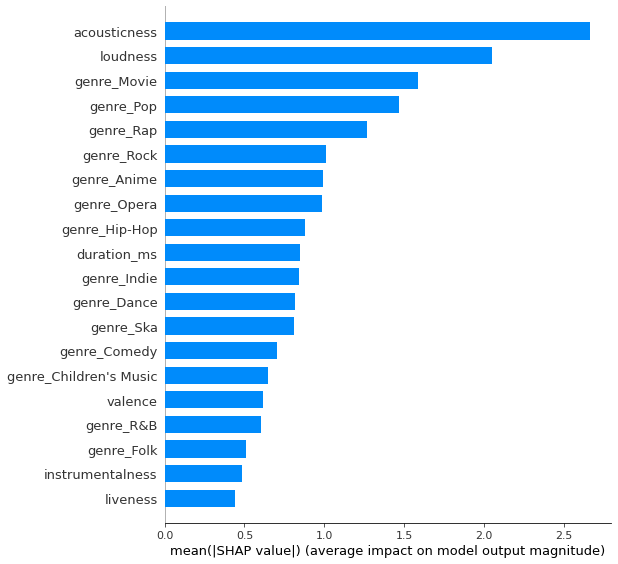

In [50]:
shap.summary_plot(train_lgbm_shap_values, X_train_enc, plot_type="bar")

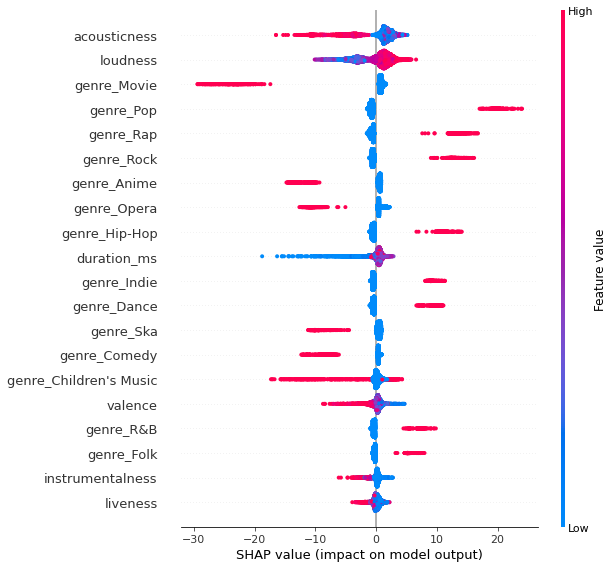

In [51]:
shap.summary_plot(train_lgbm_shap_values, X_train_enc)

#### Interpretation

- According to the bar plot above (first plot) which ranks the features based on average impact magnitude on the train set, `accousticness` seems to be the most important feature followed by `loudness` and `genre_movies`.  
- In the second plot, we see the same ordering for the features but this time we can see how lower vs higher feature values contribute to shapley values for each feature. This is all train examples with their distribution for each feature and we see how changing feature values pulls the result (SHAP value) to the positive or negative side. Fore example we can see that higher values of genre movie reduce shapley value while lower values give very low positive shapley scores.

<br><br>

### 4.3 SHAP force plots


We can also get explanations for particular predictions with SHAP. Below, I'm showing force plots of a couple of examples from the test set.


For better display of the force plot, let's round off feature values. 

In [52]:
X_train_enc = X_train_enc.round(3)
X_test_enc = X_test_enc.round(3)

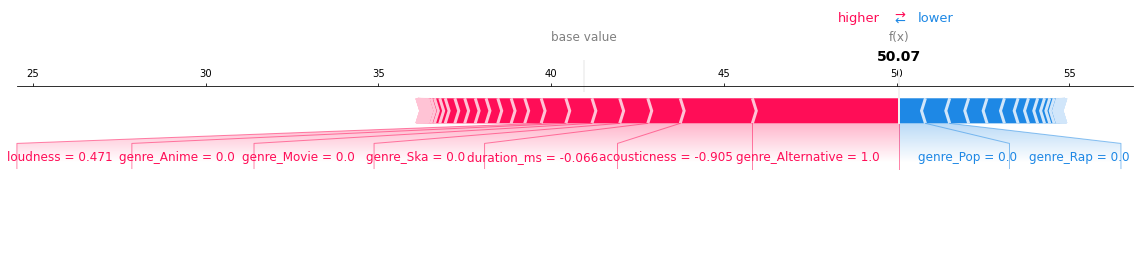

In [53]:
shap.force_plot(
    lgbm_explainer.expected_value,
    test_lgbm_shap_values[8],
    X_test_enc.iloc[8, :], 
    matplotlib=True,
)

In [54]:
true_8 = y_test.iloc[8]
true_8

50

In [55]:
round(lgbm_explainer.expected_value, 2)

40.94

#### Interpretation
For the above example the true y value is 50, and our shapley is giving a score of 50.07. The force plot shows that our expected base value is 40.94, and how the value of each feature has pushed the prediction to 50.07. The size of each feature show magnitude and the color shows whether they are positively contributing to the value or negatively. In the above example, `accousticness` and `genre_Alternative` are the features with the highest impact on increasing the prediction value away from the estimated value.

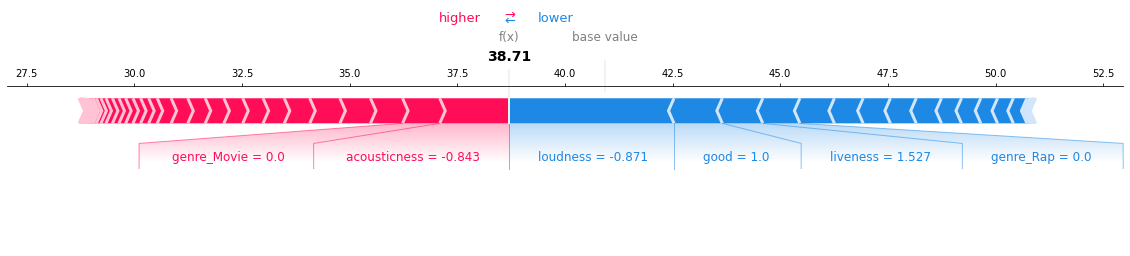

In [56]:
shap.force_plot(
    lgbm_explainer.expected_value,
    test_lgbm_shap_values[6],
    X_test_enc.iloc[6, :],
    matplotlib=True,
)

In [57]:
true_6 = y_test.iloc[6]
true_6

41

#### Interpretation
In the above example we can see that the values for `loudness`, `good` and `liveness` have been pushing the prediction (41) to the values lower than our estimated base value (40.94), while the values for `acousticness` and `genre_Movie` have been pushing the prediction to higher values the most. The overal sum of these values are 38.71 which shows how the sum of all these shapley values have brought the result to a prediction lower than the base value.